In [1]:
!pip install seaborn
!pip install albumentations

In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import albumentations as A

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# img = cv.imread('data/testing/0/10.png')
# img.shape
# # img = img[:,:,::-1] or
# img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
# plt.imshow(img)

# DATASET

In [4]:
class MNIST(Dataset):
    def __init__(self, train=False):

        super().__init__()
        
        self.img_paths = []
        self.img_labels = []

        classes = [i for i in range(0,10)]

        for i in classes:
            paths = glob(f"./data/training/{i}/*")

            for path in paths:
                self.img_paths.append(path)
                self.img_labels.append(i)
                
            paths = glob(f"./data/testing/{i}/*")

            for path in paths:
                self.img_paths.append(path)
                self.img_labels.append(i)

        img_train, img_test, label_train, label_test = train_test_split(self.img_paths, self.img_labels, random_state=123, test_size=0.2)

        if train:
            self.img_paths = img_train
            self.img_labels = label_train
        else:
            self.img_paths = img_test
            self.img_labels = label_test
        #note: resize the image according to your models specifications
        self.transform = A.Compose([
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=15,p=0.25),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, i):
        img_path = self.img_paths[i]
        label = self.img_labels[i]

        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        transformed = self.transform(image = img)
        img = transformed['image']

        img = img.transpose(2,0,1)
        img_tensor = torch.tensor(img, dtype=torch.float)/255
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor

# DATALOADER

In [5]:
train_df = MNIST(train=True)
train_loader = DataLoader(
    train_df,
    batch_size=16,
    num_workers = 2,
    drop_last=True,
    shuffle=True
)

In [6]:
test_df = MNIST(train=False)
test_loader = DataLoader(
    test_df,
    drop_last=False,
    batch_size=16,
    num_workers=2,
    shuffle=False
)

In [7]:
img, label = train_df[12]
img.shape

torch.Size([3, 28, 28])

# MODEL

In [8]:
class Model(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10,kernel_size= 3,padding= 3,stride= 1)
        self.norm1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3, padding=3, stride=1)
        self.norm2 = nn.BatchNorm2d(20)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        #linear layers we have to calculate sizes for this
        self.lin1 = nn.Linear(20*10*10,100)
        self.lin2 = nn.Linear(100,num_classes)

        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self,x):
        #shape = (batch size, channels, height, width)
        #input = (16, 3,28,28)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        #shape = (16,10,16,16)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool(x)

        #shape = (16,20,10,10)
        x = x.view(-1, 20*10*10)
        x = self.dropout(x)

        #shape = (16,20*10*10)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        #shape = (16,100)
        
        x = self.lin2(x)
        #shape = (16,1)
        
        x = self.softmax(x)
        return x

# TRAINING AND VALIDATION

In [9]:
model = Model()
model.to(DEVICE)

Model(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (lin1): Linear(in_features=2000, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [10]:
#loss function
criterion = nn.CrossEntropyLoss()
#optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def training_fxn(train_loader, model, criterion, optimizer):
    losses = []

    model.train()
    progress = tqdm(train_loader, total = len(train_loader))

    for imgs, labels in progress:
        imgs.to(DEVICE)
        labels.to(DEVICE)

        #forward propogation
        y_pred = model(imgs)
        loss = criterion(y_pred, labels)

        #backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return np.mean(losses)

In [12]:
def validation_fxn(test_loader, model, criterion, optimizer):
    losses = []

    model.eval()
    progress = tqdm(test_loader, total = len(test_loader))

    for imgs, labels in progress:
        imgs.to(DEVICE)
        labels.to(DEVICE)

        with torch.no_grad():
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)

        losses.append(loss.item())
    return np.mean(losses)

In [13]:
epochs = 25

train_losses = []
val_losses = []

best_dict = None
best_loss = np.inf

for i in range(epochs):
    print('='*5 + f" Epoch {i+1} " + '='*5)

    training_loss = training_fxn(train_loader, model, criterion, optimizer)
    val_loss = validation_fxn(test_loader, model, criterion, optimizer)

    if val_loss<best_loss:
        best_loss = val_loss
        best_dict = model.state_dict()

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    print(f"Epoch {i} - Train Loss {training_loss:.4f} - Val Loss {val_loss:.4f}\n")

===== Epoch 1 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.5616 - Val Loss 1.4960

===== Epoch 2 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 1 - Train Loss 1.5019 - Val Loss 1.4873

===== Epoch 3 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 2 - Train Loss 1.4966 - Val Loss 1.4821

===== Epoch 4 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 3 - Train Loss 1.4919 - Val Loss 1.4853

===== Epoch 5 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 4 - Train Loss 1.4895 - Val Loss 1.4814

===== Epoch 6 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 5 - Train Loss 1.4893 - Val Loss 1.4795

===== Epoch 7 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 6 - Train Loss 1.4863 - Val Loss 1.4796

===== Epoch 8 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 7 - Train Loss 1.4865 - Val Loss 1.4807

===== Epoch 9 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 8 - Train Loss 1.4867 - Val Loss 1.4779

===== Epoch 10 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 9 - Train Loss 1.4854 - Val Loss 1.4783

===== Epoch 11 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 10 - Train Loss 1.4850 - Val Loss 1.4795

===== Epoch 12 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 11 - Train Loss 1.4850 - Val Loss 1.4814

===== Epoch 13 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 12 - Train Loss 1.4834 - Val Loss 1.4758

===== Epoch 14 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 13 - Train Loss 1.4823 - Val Loss 1.4792

===== Epoch 15 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 14 - Train Loss 1.4834 - Val Loss 1.4753

===== Epoch 16 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 15 - Train Loss 1.4826 - Val Loss 1.4756

===== Epoch 17 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 16 - Train Loss 1.4823 - Val Loss 1.4761

===== Epoch 18 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 17 - Train Loss 1.4819 - Val Loss 1.4776

===== Epoch 19 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 18 - Train Loss 1.4826 - Val Loss 1.4758

===== Epoch 20 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 19 - Train Loss 1.4838 - Val Loss 1.4747

===== Epoch 21 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 20 - Train Loss 1.4815 - Val Loss 1.4797

===== Epoch 22 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 21 - Train Loss 1.4817 - Val Loss 1.4762

===== Epoch 23 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 22 - Train Loss 1.4814 - Val Loss 1.4730

===== Epoch 24 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 23 - Train Loss 1.4807 - Val Loss 1.4747

===== Epoch 25 =====


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 24 - Train Loss 1.4806 - Val Loss 1.4748



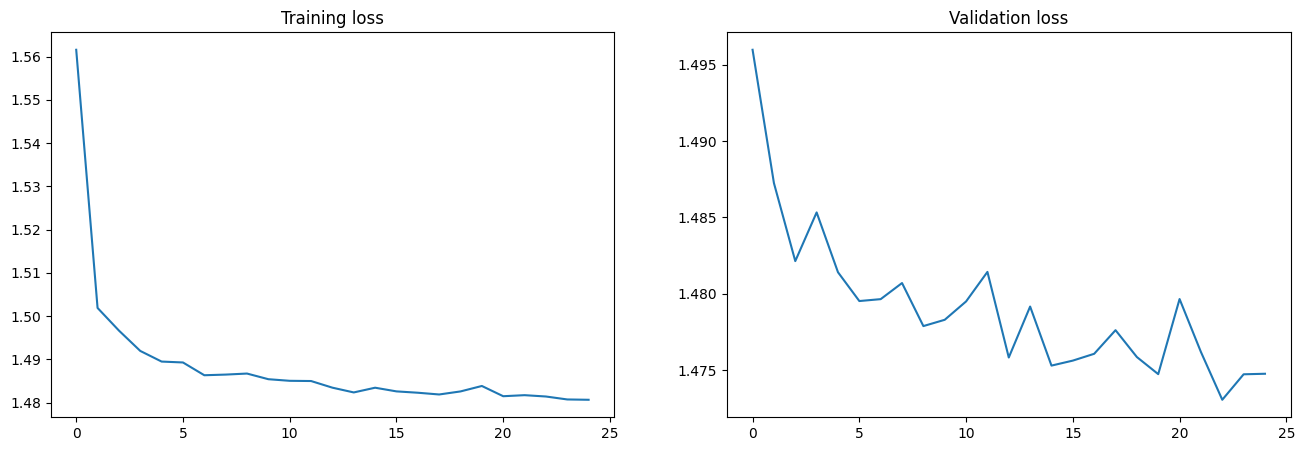

In [14]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.title("Training loss")
plt.plot(train_losses)

plt.subplot(1,2,2)
plt.title("Validation loss")
plt.plot(val_losses)

# EVALUATION

In [15]:
val_preds = []
val_true = []

progress = tqdm(test_loader, total = len(test_loader))

model.eval()

for imgs, labels in progress:
    imgs.to(DEVICE)
    labels.to(DEVICE)

    with torch.no_grad():
        y = model(imgs)

    #shape of y is (16,10) since the batch size is 16 so 16 rows and softmax gives probability of each class
    preds = np.argmax(y.cpu().numpy(), axis=1)#we need to convert the tensor to numpy
    val_preds.extend(preds.tolist())
    val_true.extend(labels.cpu().numpy().tolist())

  0%|          | 0/875 [00:00<?, ?it/s]

In [16]:
metrics.accuracy_score(val_preds, val_true)

0.9863571428571428

Text(0.5, 47.7222222222222, 'Predicted label')

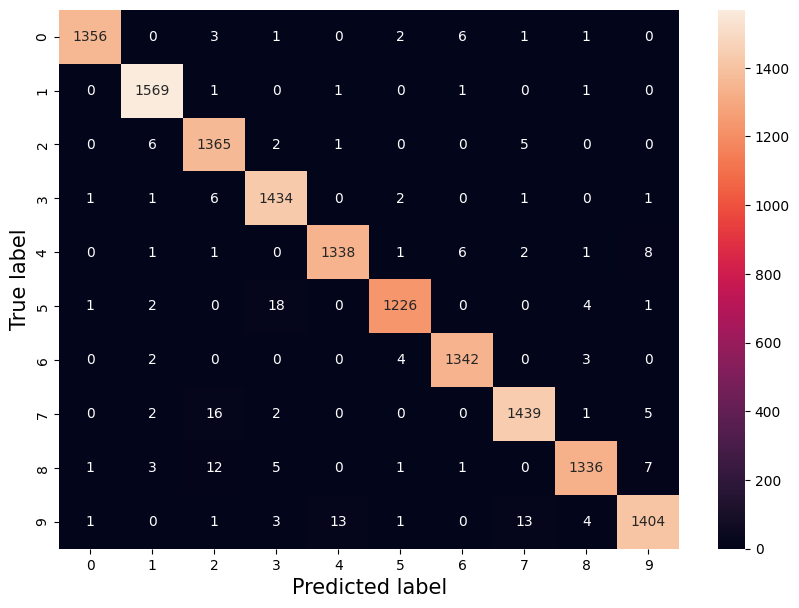

In [17]:
cm = metrics.confusion_matrix(val_preds, val_true)
cm_df = pd.DataFrame(cm, columns = [i for i in range(0,10)], index = [i for i in range(0,10)])

plt.figure(figsize=(10,7))

sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)

In [18]:
torch.save(model.state_dict(), "model_weights.pth")